In [3]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#From signac
import signac
meth_name_val_list = [1, 2, 3, 4, 5, 6]
save_csv = False

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": {"$gte": 1},
                 "meth_name_val": {"$in": meth_name_val_list}}

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": 1,
                 "meth_name_val": {"$in": meth_name_val_list}}

print(make_dir_name_from_criteria(criteria_dict))

# criteria_dict = {"cs_name_val" : 1,
#                  "param_name_str" : "t1t2",
#                  "ep_enum_val":1,
#                  "retrain_GP": 25,
#                  "num_x_data": 5,
#                  "outputscl": None,
#                  "bo_iter_tot": 50,
#                  "lenscl": None}

df, job_list, theta_true = get_df_all_jobs(criteria_dict, save_csv)

In [ ]:
### Get Best Data from ep experiment
df_best, job_list_best = get_best_data(criteria_dict, df, job_list, theta_true, save_csv)

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)
    
df_best

In [ ]:
run_num_list = list(map(int, df_best["Run Number"].to_numpy()))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy()))
bo_method_list = list(df_best["BO Method"].to_numpy())

In [ ]:
z_choices = ["min_sse"]

title_fontsize = 24
other_fontsize = 24
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = r"$\mathbf{e(\theta)}$"
# y_label = "Max " + r"$\mathbf{EI(\theta)}$"
title = None
save_path = None
log_data = False

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_method_sse_one_plot(file_path_list, bo_method_list, run_num_list, z_choices, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
title_fontsize = 24
other_fontsize = 24
xbins = 4
ybins = 5
zbins = 900
save_path = None
cmap = "autumn"
pair = 0
log_data = True

title = "Heat Map Pair "
z_choice = "sse_mean"
title = "Heat Map Pair " + z_choice
title = None
levels = [100,100,100, 100, 100, 100]

pair = 0

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

compare_method_heat_maps(file_path_list, bo_method_list, run_num_list, bo_iter_list, pair, 
                         z_choice, log_data, levels, xbins, ybins, zbins, title, title_fontsize, other_fontsize, 
                         cmap, save_path)

In [ ]:
#Make Sample heat maps
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_fig = False
cmap = "autumn"
log_data = True

#Get Best Data from ep experiment
df_best, job_list_best = get_best_data(criteria_dict, df, job_list, theta_true, save_csv)

#Loop over best jobs
for i in range(len(job_list_best)):    
    run_num = run_num_list[i]
    bo_iter = bo_iter_list[i]
    file_path = job_list_best[i].fn("BO_Results.gz")
    string_val = df_best["Theta Min Obj"].iloc[0]
    try:
        numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    except:
        numbers = [float(num) for num in string_val]
    dim_theta = np.array(numbers).reshape(-1, 1)
    dim_theta = len(dim_theta)
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    pair = 0
    
    get_ei = False
    analysis_list = analyze_heat_maps(file_path, run_num, bo_iter, pair, log_data, get_ei)
    sim_sse_var_ei, test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, idcs_to_plot = analysis_list
    sse_sim, sse_mean, sse_var, ei = sim_sse_var_ei

    title = "Heat Map Pair " + "-".join(map(str, plot_axis_names))
    title = None
#     z = [sse_sim, sse_mean, sse_var, ei]
#     z_titles = ["ln(sse_sim)", "ln(sse)", "ln(sse_var)", "log(ei)"]
#     levels = [100,100,100, 100]
    z = [sse_sim, sse_mean]
    z_titles = ["ln(sse_sim)", "ln(sse)"]
    levels = [100,100]
#     z = [sse_mean]
#     z_titles = [meth_names[i] + " log("+ r"$\mathbf{e(\theta)}$" + ")"]
       
    save_path = job_list[i].fn("Results/" + make_dir_name_from_criteria(criteria_dict) + "/")
    
    if save_fig == False:
        save_path = None

    plot_heat_maps(test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, levels, idcs_to_plot, 
                   z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)

In [ ]:
z_choices = "ei"

title_fontsize = 24
other_fontsize = 24
xbins = 5
ybins = 7
x_label = "BO Iterations"
# y_label = r"$\mathbf{e(\theta)}$"
y_label = "Max " + r"$\mathbf{EI(\theta)}$"
title = "Min SSE Values"
title = None
save_path = None
log_data = False

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_compare_method_ei_sse(file_path_list, bo_method_list, run_num_list, z_choices, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
# #Get Median Data from sf experiment
df_median, job_list_med = get_median_data(criteria_dict, df, job_list, theta_true, save_csv)

for i in range(len(job_list_med)): 
    print(job_list_med[i].id)
    
df_median

In [ ]:
# #Get Mean Data from sf experiment
df_mean, job_list_mean = get_mean_data(criteria_dict, df, job_list, theta_true, save_csv)

for i in range(len(job_list_mean)): 
    print(job_list_mean[i].id)
    
df_mean

workspace/811c3b5e401ba0adcedd67a67dbf2457/Results/hyperparameters/hp_data.npy


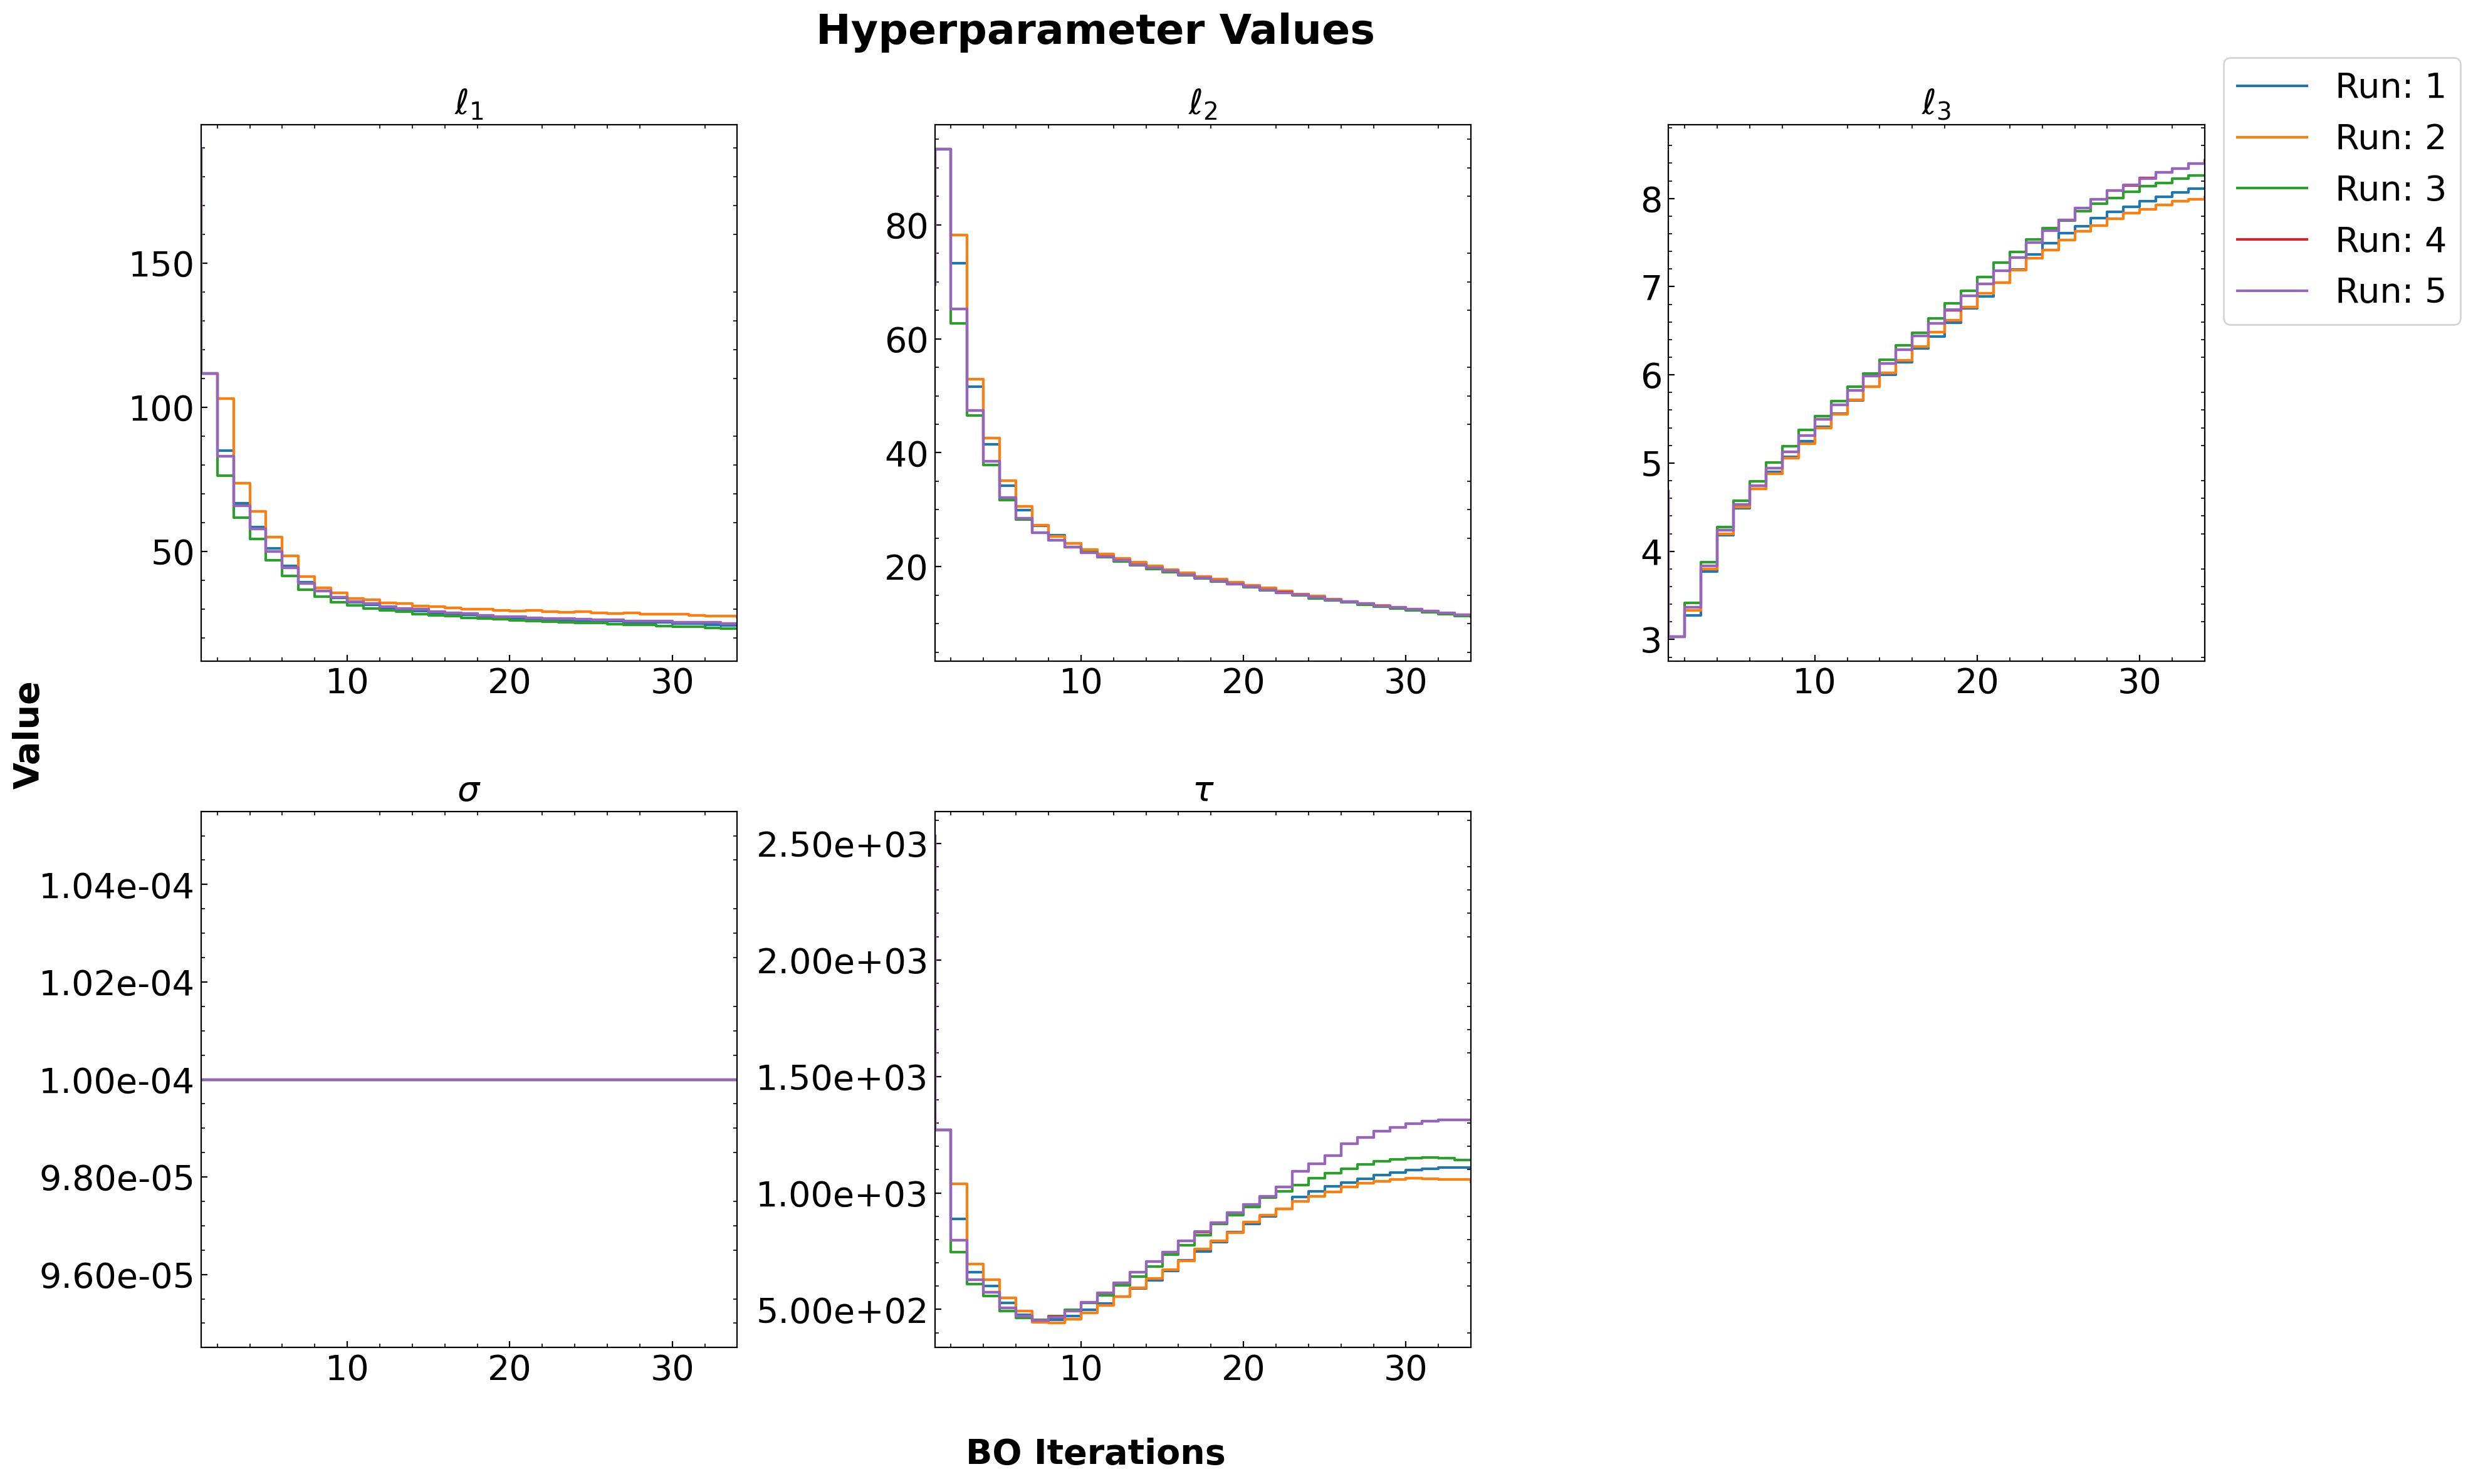

In [4]:
#Get HP Plots
#Set parameters
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = "Value"
title = "Hyperparameter Values"
save_path = None
data_true = None
log_data = False

hps, hp_names, hp_true = analyze_hypers(file_path, run_num, save_csv = True)
plot_2D_Data_w_BO_Iter(hps, hp_names, hp_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Get sse, log_sse, and ei plots
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz" #CS1 A1 Best
# file_path = "workspace/b0e257d6e76025909e364903b3b792ee/BO_Results.gz" #CS1 B1 Best
# file_path = "workspace/d0c8b17229671998f3ffdab06c79e1f9/BO_Results.gz" #CS1 A2 Best
# file_path = "workspace/fdc2673ac83f3d0cf5b3b969a3e80825/BO_Results.gz" #CS1 B2 Best
# file_path = "workspace/9042085b58a00b76d6c2ae0a20cfe9f3/BO_Results.gz" #CS1 C2 Best
# file_path = date_time_str + "Data_Files/" + name_cs_str + "_BO_method_" + "C2" + "_sep_fact_0.9.gz"

loaded_results = open_file_helper(file_path)
meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name
run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
z_choices = ["min_sse"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = "Data"
title = "Data Values"
save_path = None
log_data = True

data, data_names, data_true = analyze_sse_min_sse_ei(file_path, run_num, z_choices)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Get theta @ min sse
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
x_label = "BO Iterations"
y_label = "Theta Values"
title = "Min Obj Parameter Values"
z_choice = "sse"
save_path = None
log_data = False

data, data_names, data_true = analyze_thetas(file_path, run_num, z_choice)
print(data.shape, data_names, data_true)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Get theta @ min sse overall
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
x_label = "BO Iterations"
y_label = "Theta Values"
title = "Min Obj Parameter Values Overall"
z_choice = "min_sse"
save_path = None
log_data = False

data, data_names, data_true = analyze_thetas(file_path, run_num, z_choice)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Get theta @ Max EI
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1


title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
x_label = "BO Iterations"
y_label = "Theta Values"
title = "Max EI Parameter Values"
z_choice = "ei"
save_path = None
log_data = False

data, data_names, data_true = analyze_thetas(file_path, run_num, z_choice)
plot_2D_Data_w_BO_Iter(data, data_names, data_true, xbins, ybins, title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Visualize training data
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"
run_num = 1
bo_iter = 1

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
zbins = 5
save_path = None

idcs_to_plot = [0,1,2]

title = "Data Run 1 BO Iter 1"
train_data, test_data, val_data, x_exp, data_names, data_true = analyze_train_test(file_path, run_num, bo_iter)

plot_train_test_val_data(train_data, test_data, None, data_names, idcs_to_plot, x_exp, xbins, ybins, zbins, 
                         title, title_fontsize, other_fontsize, save_path)

In [ ]:
#Plot xy data
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_1.0.pickle"
# file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"

run_num = 1
bo_iter = 1
x_lin_pts = 50

title_fontsize = 24
other_fontsize = 20
save_path = None

xbins = 5
ybins = 5
title = "CS1 Data Comparison"
x_label = "X Value"
y_label = "y Value"

theta_opt_data, exp_data, train_data, test_data = analyze_xy_plot(file_path, run_num, bo_iter, x_lin_pts)
plot_x_vs_y_given_theta(theta_opt_data, exp_data, train_data, test_data, xbins, ybins, title, x_label, y_label, 
                        title_fontsize, other_fontsize, save_path)

In [ ]:
#Param snesitivity analysis
file_path = "2023/08/28/Data_Files/CS1_meth_A2_sep_fact_0.1.pickle"
file_path = "2023/09/05/Data_Files/CS2_BO_method_C2_ep_method_BOYLE.pickle"
# file_path = "2023/09/05/Data_Files/CS2_BO_method_B1_ep_method_CONSTANT.pickle"
file_path = "workspace/811c3b5e401ba0adcedd67a67dbf2457/BO_Results.gz"

run_num = 1
bo_iter = 1
n_points = 100
param_id = 0

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 5
save_path = None

list_of_data = analyze_param_sens(file_path, run_num, bo_iter, param_id, n_points)
param_data, param_idx, param_name, data_name, exp_data, train_data, test_data = list_of_data

title = "Param Sensitivity Analysis"
x_label = param_name
y_label = "Y Value"

data = [param_data]
data_names = [param_name]

plot_theta_vs_y_given_x(data, param_idx, data_names, exp_data, train_data, test_data, xbins, ybins, title, 
                        x_label, y_label, title_fontsize, other_fontsize, save_path)